In [1]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

In [1]:
!nvidia-smi

Tue Jun  7 17:09:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:19:00.0 Off |                  N/A |
| 37%   45C    P8    25W / 350W |    261MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
|100%   

# Import library

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, GRU
# from keras.layers import Dropout
# from keras.layers import LSTM
# from keras.callbacks import ModelCheckpoint
# from keras.utils import np_utils
# from keras.layers import Embedding
# from keras.preprocessing.sequence import pad_sequences
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# earlystopping = EarlyStopping(monitor = 'loss', verbose = 1,patience = 8, mode = 'min')
# from keras.layers import Bidirectional, GlobalMaxPool1D
# from keras.callbacks import CSVLogger

# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputSpec, Layer, Input, Embedding, Conv1D, Conv2D, Bidirectional, Dense, Attention
from tensorflow.keras.layers import LSTM, Activation, Add, Flatten, Concatenate, concatenate # CuDNNGRU, CuDNNLSTM, 
from tensorflow.keras.layers import Reshape, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D, MaxPool2D, GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K 
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam

# from tensorflow.keras.engine import Layer
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, Flatten
# from keras.layers import CuDNNGRU, CuDNNLSTM, BatchNormalization
# from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
# from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

# from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
# from keras import backend as K


import string
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import re

from glob import glob
from tqdm import tqdm

from time import time
from timeit import default_timer as timer
from datetime import timedelta, datetime

import os, re, csv, math, codecs, copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
import os, re, csv, math, codecs
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# Ploting code

In [3]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
#     from itertools import izip
    pc.update_scalarmappable()
#     ax = pc.get_axes()
    ax = pc.axes# FOR LATEST MATPLOTLIB
    
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


# def main():
#     sampleClassificationReport = """             precision    recall  f1-score   support

#           Acacia       0.62      1.00      0.76        66
#           Blossom       0.93      0.93      0.93        40
#           Camellia       0.59      0.97      0.73        67
#           Daisy       0.47      0.92      0.62       272
#           Echium       1.00      0.16      0.28       413

#         avg / total       0.77      0.57      0.49       858"""


#     plot_classification_report(sampleClassificationReport)
#     plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
#     plt.close()

# if __name__ == "__main__":
#     main()
#     #cProfile.run('main()') # if you want to do some profiling


# Import the NPZ file of our dataset

In [4]:
%%time
npsavezFile=np.load("outfile_space_20220426.npz",allow_pickle=True)
# print(npsavezFile.files)

vocab=npsavezFile['arr_1']
data=npsavezFile['arr_0']
Y=npsavezFile['arr_2']
Y=list(Y)

CPU times: user 1.21 s, sys: 113 ms, total: 1.33 s
Wall time: 1.34 s


In [5]:
vocab

array(['가가지고', '가가지고다시', '가거나', ..., '힙합하는', '힙합하면은', '힝'], dtype='<U24')

In [6]:
# np.set_printoptions(threshold=sys.maxsize)
data

array([list(['예', '고객님', '담당자', '김성도', '대리입니다예지금', '법무사님이', '두분', '배정되셨어요네', '네네', '지금', '뭐', '입증되십니까예', '예', '지금', '준비', '하고', '있어요예', '그러세요', '잠시만요', '지금', '일단', '먼저', '법무사님', '한분', '안내', '좀', '해', '드리겠습니다', '메모', '가능하십니까예', '불러주세요예', '예', '이거', '원입니다', '잠시만요', '일단', '국민은행으로', '배정되셨구요네', '국민이요불러볼게요네', '성함은', '어떻게', '돼요예', '법무사', '님이십니다', '예', '지금', '보내고', '바로', '전화', '드릴게요입니다예', '입금', '하고', '바로', '전화', '드릴게요님은', '먼저', '구십팔', '원이세요예', '구십팔만원이요예', '나머지', '차액', '백오십', '이만원을', '네네', '다른', '법무사님', '배정', '받으셔야', '됩니다', '법무사님', '오늘', '이제', '금요일', '정시', '퇴근하셔서', '일단', '법무사님이', '구십팔만', '원이십니다예', '알겠습니다', '또', '돌아', '가면요', '우선은', '법무사님', '구십팔만원', '상환', '처리하신', '다음에', '전화', '좀', '바로', '좀', '부탁드릴게요', '저도', '법무사님', '빠르게', '지금', '배정', '요청', '중에', '있으니까요예', '예제가', '지금', '빠르게해서', '금요일', '여섯', '시까지', '영수증', '확인', '돼가지고', '여섯', '반에는', '자금', '수령', '제가', '문제', '없도록', '도움', '드리겠습니다네', '대리님도', '수고', '많으셨습니다네', '차액부분', '백오십', '이만원', '배정', '받으시면', '부탁좀', '드리겠습니다예', '예', '알겠습니다네']),
       list(['본인', '성함', 

In [7]:
# print(data.dtype)

In [8]:
%%time
max_length=max([len(i) for i in data])
#print("max_length",max_length) # max_length 35

# print(sorted([len(i) for i in data]))

CPU times: user 439 µs, sys: 81 µs, total: 520 µs
Wall time: 525 µs


In [9]:
%%time
word_id=dict((c,i) for i,c in enumerate(vocab))
id_word=dict((i,c) for i,c in enumerate(vocab))
# print("word_id",word_id)
# print('*'*100)
# print("id_word",id_word)

CPU times: user 367 ms, sys: 14.8 ms, total: 382 ms
Wall time: 384 ms


In [10]:
%%time
X_train=[]
for sentence in data:
    x=[]
    for word in sentence:
        app=word_id[word]
        x.append(app)
        
    X_train.append(x)
 
#  # Map for readable classnames
# class_names = [0, 1]

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.52 s


In [11]:
%%time
max_length=max([len(i) for i in X_train])

encoded = pad_sequences(X_train, maxlen=max_length, padding='pre')
encoded=np.array(encoded)
print("encoded shape",encoded.shape) #encoded shape (12924, 35)
print("max_length", max_length)

#encoded=np.true_divide(encoded, 500)
#standard_scaler = StandardScaler()
#robust_scaler = RobustScaler()
#encoded = standard_scaler.fit_transform(encoded)

length_encoded=len(encoded)

encoded shape (2924, 5962)
max_length 5962
CPU times: user 251 ms, sys: 171 ms, total: 421 ms
Wall time: 425 ms


# Import the Korean fastText pre-trained model and perform the emebeddings


In [12]:
%%time
# run if the wiki.ko.vec is not available
# import os
# import urllib.request
# urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec')

CPU times: user 0 ns, sys: 8 µs, total: 8 µs
Wall time: 13.6 µs


In [13]:
%%time
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('wiki.ko.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# embeddings_index

loading word embeddings...


879131it [01:20, 10883.77it/s]

CPU times: user 1min 19s, sys: 1.9 s, total: 1min 20s
Wall time: 1min 20s


In [14]:
# %%time
MAX_NB_WORDS=len(vocab)
print('found %s word vectors' % len(embeddings_index))
print("tokenizing input data...")

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False, char_level=False)
tokenizer.fit_on_texts(data)  #leaky
word_seq_train = tokenizer.texts_to_sequences(data)
word_seq_test = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

found 879130 word vectors
tokenizing input data...
dictionary size:  255367


In [15]:
%%time
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
embed_dim = 300 # 32 Dimensions of the embedding vector
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((MAX_NB_WORDS, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 172223
sample words not found:  ['개그라고' '남북문제도' '시끄럽' '주시고요네네' '건강했는데' '짜빠구리에' '여사님께서는' '배우들이나' '놔야지'
 '빠져있었었어요']
CPU times: user 508 ms, sys: 169 ms, total: 677 ms
Wall time: 693 ms


# Split the dataset/embedding matrice

In [16]:
%%time
Y_train=np.array(Y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(encoded, Y_train, test_size=0.1, random_state=42, shuffle= True)

# Vectorize the output sentence type classifcations to Keras readable format
y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

CPU times: user 35.7 ms, sys: 12.1 ms, total: 47.7 ms
Wall time: 47.1 ms


In [17]:
# %%time
# numericalization of the text into numbers
# X_train = tfidf.fit_transform(df_train['transcript']).toarray()
# X_test = tfidf.transform(df_test['transcript']).toarray()

# Y_=np.array(Y)

# Split the data in train and test set, reseve 10% of the for the test set
# X_train, X_test, y_train, y_test = train_test_split(
#     encoded,
#     Y_,
#     test_size=0.1,
#     random_state=42, 
#     shuffle= True
# )

# slip the train set in train and eval, reseve 10% of the data for thse evaluation
# X_train_sub, X_val, y_train_sub, y_val = train_test_split(
#     X_train,
#     y_train, 
#     test_size=0.11111111111111111111111111111,
#     random_state=42, 
#     shuffle= True
# )

# y_train_sub=to_categorical(y_train_sub,num_classes=2)
# y_val=to_categorical(y_val,num_classes=2)
# y_test=to_categorical(y_test,num_classes=2)

In [18]:
# check the shape of each set
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

# print("X_train_sub shape: {}".format(X_train_sub.shape))
# print("y_train_sub shape: {}".format(y_train_sub.shape))

# print("X_val shape: {}".format(X_val.shape))
# print("y_val shape: {}".format(y_val.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (2631, 5962)
y_train shape: (2631, 2)
X_test shape: (293, 5962)
y_test shape: (293, 2)


In [19]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 2631 
Test set size = 293


# Build Text 2D CNN Model
##### https://www.kaggle.com/mlwhiz/textcnn-pytorch-and-keras

In [20]:
# batch_size = 512 # how many samples to process at once
# n_epochs = 5 # how many times to iterate over all samples
# n_splits = 5 # Number of K-fold Splits
# SEED = 10

In [21]:
def model_train_cv(x_train,y_train,nfold,model_obj):
    splits = list(StratifiedKFold(n_splits=nfold, shuffle=True, random_state=SEED).split(x_train, y_train))
    x_train = x_train
    y_train = np.array(y_train)
    # matrix for the out-of-fold predictions
    train_oof_preds = np.zeros((x_train.shape[0]))
    for i, (train_idx, valid_idx) in enumerate(splits):
        print(f'Fold {i + 1}')
        x_train_fold = x_train[train_idx.astype(int)]
        y_train_fold = y_train[train_idx.astype(int)]
        x_val_fold = x_train[valid_idx.astype(int)]
        y_val_fold = y_train[valid_idx.astype(int)]

        clf = copy.deepcopy(model_obj)
        clf.fit(x_train_fold, y_train_fold, batch_size=512, epochs=5, validation_data=(x_val_fold, y_val_fold))
        
        valid_preds_fold = clf.predict(x_val_fold)[:,0]

        # storing OOF predictions
        train_oof_preds[valid_idx] = valid_preds_fold
    return train_oof_preds

In [22]:
def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.501, 0.01)):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta , tmp[2]

In [23]:
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(max_length,))
    x = Embedding(MAX_NB_WORDS, embed_dim, weights=[embedding_matrix])(inp)
    x = Reshape((max_length, embed_dim, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_dim),
                                     kernel_initializer='he_normal', activation='relu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(max_length - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    
    return model

In [24]:
# model = model_cnn(embedding_matrix)

In [25]:
# %%time
# train_oof_preds = model_train_cv(X_train,y_train,5,model)

In [26]:
# Text 2D CNN
# delta, _ = bestThresshold(y_train,train_oof_preds)

# Build BiLSTM
##### https://www.kaggle.com/code/mlwhiz/bilstm-pytorch-and-keras/notebook

In [27]:
def model_train_cv(x_train,y_train,nfold,model_obj):
    splits = list(StratifiedKFold(n_splits=nfold, shuffle=True, random_state=SEED).split(x_train, y_train))
    x_train = x_train
    y_train = np.array(y_train)
    # matrix for the out-of-fold predictions
    train_oof_preds = np.zeros((x_train.shape[0]))
    for i, (train_idx, valid_idx) in enumerate(splits):
        print(f'Fold {i + 1}')
        x_train_fold = x_train[train_idx.astype(int)]
        y_train_fold = y_train[train_idx.astype(int)]
        x_val_fold = x_train[valid_idx.astype(int)]
        y_val_fold = y_train[valid_idx.astype(int)]

        clf = copy.deepcopy(model_obj)
        clf.fit(x_train_fold, y_train_fold, batch_size=512, epochs=5, validation_data=(x_val_fold, y_val_fold))
        
        valid_preds_fold = clf.predict(x_val_fold)[:,0]

        # storing OOF predictions
        train_oof_preds[valid_idx] = valid_preds_fold
    return train_oof_preds

In [28]:
# BiDirectional LSTM

def model_lstm_du(embedding_matrix):
    inp = Input(shape=(max_length,))
    x = Embedding(MAX_NB_WORDS, embed_dim, weights=[embedding_matrix],trainable=False)(inp)
    '''
    Here 64 is the size(dim) of the hidden state vector as well as the output vector. 
    Keeping return_sequence we want the output for the entire sequence. So what is the dimension of output for this layer?
        64*70(maxlen)*2(bidirection concat)
    CuDNNLSTM is fast implementation of LSTM layer in Keras which only runs on GPU
    '''
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    
    return model

In [29]:
# model = model_lstm_du(embedding_matrix)

In [30]:
# %%time
# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# try:
#     # Specify an invalid GPU device
#     with tf.device('/device:GPU:1'):
#         train_oof_preds = model_train_cv(X_train,y_train,5,model)
# except RuntimeError as e:
#     print(e)

# Build the Attention-Based CNN-BiLSTM Model
## That model is a model that performs a binary classification problem
### https://wikidocs.net/80783
### https://wikidocs.net/85337
### https://www.kaggle.com/code/duykhanh99/bidirectional-lstm-cnn-attention-model/notebook
### https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566

In [31]:
# model = Sequential()
# # input layer
# model.add(Embedding(MAX_NB_WORDS, embed_dim))
# model.add(Dropout(dropout_ratio))

# # the CNN layers
# model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
# # maxpooling operation
# model.add(GlobalMaxPooling1D())
# # fully connected layer is additionally used as a hidden layer
# model.add(Dense(hidden_units, activation='relu'))
# model.add(Dropout(dropout_ratio))

# # BiLSTM layers


# # Attention Layer


# #classification layer
# model.add(Dense(1, activation='sigmoid'))

In [32]:
# # EarlyStopping monitor the overfitting issue on the validation data loss value
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# # Use ModelCheckpoint to save the model only when the validation data's accuracy (val_acc) is better than before. 
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [34]:
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[es, mc])

## Bahdanau Attention
##### https://wikidocs.net/48920

In [35]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## Feed-Forward Networks with Attention Can Solve Some Long-Term Memory Problems
###### https://arxiv.org/abs/1512.08756

In [36]:
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## Hierarchical Attention Networks for Document Classification
##### http://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

In [37]:
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
# https://www.kaggle.com/code/duykhanh99/bidirectional-lstm-cnn-attention-model/notebook
    
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy}


class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
        
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "arg1": self.arg1,
#             "arg2": self.arg2,
#         })
#         return config     
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Training the models

In [38]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])

In [39]:
# defining the hyperparameters
learning_rate = 1e-3
learning_decay = 1e-10 # 1e-4
batch_size= 64 # 128
epochs = 10

spa_dropout_ratio = 0.2 # dropout ration, droping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.1 # 0.1 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.

## Att CNN-BiLSTM Model

In [40]:
def build_model_1(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length = max_length,
        weights = [embedding_matrix], 
        trainable = False,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(2, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = Adam(learning_rate=lr, decay=lr_d),
#         optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "best_Attention_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="Att_cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history_1 = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.11111111111111111111111111111,
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test, y_test) # or model.predict
    
    return model, history_1, train_time

In [41]:
# Train proposed model
model_1, history_1, train_time = build_model_1(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

2022-06-07 17:11:20.490148: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 17:11:24.984463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22053 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2022-06-07 17:11:24.987221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 16973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-06-07 17:11:24.988484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5962)]            0         
                                                                 
 embedding (Embedding)       (None, 5962, 300)         81193800  
                                                                 
 spatial_dropout1d (SpatialD  (None, 5962, 300)        0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 5960, 50)          45050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2980, 50)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2980, 50)          0     

2022-06-07 17:11:35.988202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-06-07 17:11:37.410548: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-07 17:11:37.415047: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-07 17:11:37.416323: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-07 17:11:37.416342: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at /usr/local/cuda/bin/ptxas
2022-06-07 17:11:37.416604: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: /usr/loc

37/37 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8084
Epoch 1: val_loss improved from inf to 0.17855, saving model to best_Attention_CNN_BiLSTM_20220607_17-11-28.hdf5


2022-06-07 17:11:53.087223: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324775200 exceeds 10% of free system memory.


37/37 [==============================] - 26s 384ms/step - loss: 0.3936 - accuracy: 0.8084 - val_loss: 0.1786 - val_accuracy: 0.9693
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9641
Epoch 2: val_loss improved from 0.17855 to 0.11150, saving model to best_Attention_CNN_BiLSTM_20220607_17-11-28.hdf5


2022-06-07 17:12:05.786328: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324775200 exceeds 10% of free system memory.


37/37 [==============================] - 13s 350ms/step - loss: 0.1407 - accuracy: 0.9641 - val_loss: 0.1115 - val_accuracy: 0.9659
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9743
Epoch 3: val_loss improved from 0.11150 to 0.09469, saving model to best_Attention_CNN_BiLSTM_20220607_17-11-28.hdf5


2022-06-07 17:12:18.639580: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324775200 exceeds 10% of free system memory.


37/37 [==============================] - 13s 347ms/step - loss: 0.0960 - accuracy: 0.9743 - val_loss: 0.0947 - val_accuracy: 0.9761
Epoch 4/10
37/37 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9748
Epoch 4: val_loss did not improve from 0.09469
37/37 [==============================] - 12s 313ms/step - loss: 0.0788 - accuracy: 0.9748 - val_loss: 0.1331 - val_accuracy: 0.9625
Epoch 5/10
37/37 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9790
Epoch 5: val_loss improved from 0.09469 to 0.02238, saving model to best_Attention_CNN_BiLSTM_20220607_17-11-28.hdf5


2022-06-07 17:12:43.045638: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324775200 exceeds 10% of free system memory.


37/37 [==============================] - 13s 345ms/step - loss: 0.0703 - accuracy: 0.9790 - val_loss: 0.0224 - val_accuracy: 0.9863
Epoch 6/10
37/37 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9837
Epoch 6: val_loss did not improve from 0.02238
37/37 [==============================] - 12s 313ms/step - loss: 0.0483 - accuracy: 0.9837 - val_loss: 0.0246 - val_accuracy: 0.9898
Epoch 7/10
37/37 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9902
Epoch 7: val_loss did not improve from 0.02238
37/37 [==============================] - 12s 314ms/step - loss: 0.0253 - accuracy: 0.9902 - val_loss: 0.0402 - val_accuracy: 0.9898
Epoch 8/10
37/37 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9927
Epoch 8: val_loss improved from 0.02238 to 0.01995, saving model to best_Attention_CNN_BiLSTM_20220607_17-11-28.hdf5
37/37 [==============================] - 13s 357ms/step - loss: 0.0232 - accuracy: 0.9927 - val_loss: 0.0200 - 

In [42]:
# # graph of the training
# pd.DataFrame(history.history).plot(figsize=(12, 8))
# plt.grid(True)
# plt.legend()
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.xlabel('epochs')
# plt.show()
# # plt.savefig('Att-Based CNN-BiLSTM_all_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png')
# plt.savefig('CNN-BiLSTM_all_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png')

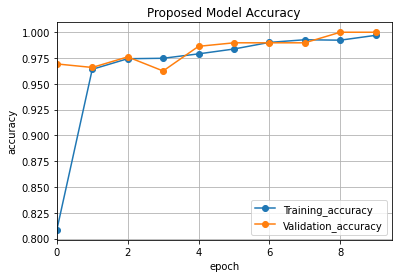

In [43]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history_1.epoch, history_1.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('Proposed Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('Att-Based CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('Att-Based CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

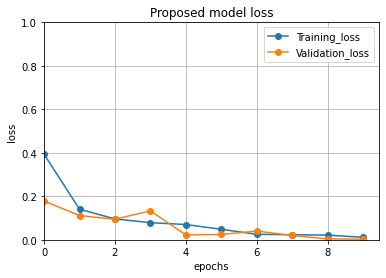

In [44]:
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history_1.epoch, history_1.history['loss'], '-o', label='Training_loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Validation_loss')
plt.title('Proposed model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('Att-Based CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('Att-Based CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [45]:
predicted = model_1.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9913    1.0000    0.9956       228
           1     1.0000    0.9692    0.9844        65

    accuracy                         0.9932       293
   macro avg     0.9957    0.9846    0.9900       293
weighted avg     0.9932    0.9932    0.9931       293



In [46]:
# sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

In [47]:
plot_classification_report(report)
plt.savefig('Att-Based CNN-BiLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.close()

[0.9913, 1.0, 0.9956]
[1.0, 0.9692, 0.9844]
plotMat: [[0.9913, 1.0, 0.9956], [1.0, 0.9692, 0.9844]]
support: [228, 65]


In [48]:
# df = pd.DataFrame(report).transpose()
# df.to_csv('Att-Based CNN-BiLSTM_class_report_'+ datetime.now().strftime("%Y%m%d") + '.csv')
# print(df)

In [49]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

Testing Accuracy: 0.993174
Testing Precision: 0.993233
Testing Recall: 0.993174
Testing F1 score: 0.993136


In [50]:
# append the results
df_results.loc['Att-Based CNN-BiLSTM'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM,0.993136,0.993233,0.993174,0.993174,137.829258


## CNN-BiLSTM model

In [51]:
%%time
Y_train=np.array(Y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(encoded, Y_train, test_size=0.1, random_state=42, shuffle= True)

# Vectorize the output sentence type classifcations to Keras readable format
y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

CPU times: user 13.4 ms, sys: 8.16 ms, total: 21.5 ms
Wall time: 19.2 ms


In [52]:
# check the shape of each set
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

# print("X_train_sub shape: {}".format(X_train_sub.shape))
# print("y_train_sub shape: {}".format(y_train_sub.shape))

# print("X_val shape: {}".format(X_val.shape))
# print("y_val shape: {}".format(y_val.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (2631, 5962)
y_train shape: (2631, 2)
X_test shape: (293, 5962)
y_test shape: (293, 2)


In [53]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 2631 
Test set size = 293


In [54]:
def build_model_2(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length = max_length,
        weights = [embedding_matrix], 
        trainable = False,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(2, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = Adam(learning_rate=lr, decay=lr_d),
#         optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "best_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.11111111111111111111111111111,
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test, y_test) # or model.predict
    
    return model, history, train_time

In [55]:
# Train proposed model
model_2, history_5, train_time = build_model_2(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5962)]            0         
                                                                 
 embedding (Embedding)       (None, 5962, 300)         81193800  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 5962, 300)        0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 5960, 50)          45050     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2980, 50)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 2980, 50)          0   

In [56]:
# # graph of the training
# pd.DataFrame(history.history).plot(figsize=(12, 8))
# plt.grid(True)
# plt.legend()
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.xlabel('epochs')
# plt.show()
# # plt.savefig('Att-Based CNN-BiLSTM_all_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png')
# plt.savefig('CNN-BiLSTM_all_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png')

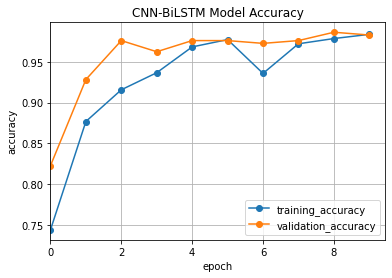

In [57]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


plt.plot(history_5.epoch, history_5.history['accuracy'], '-o', label='training_accuracy')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='validation_accuracy')
plt.title('CNN-BiLSTM Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

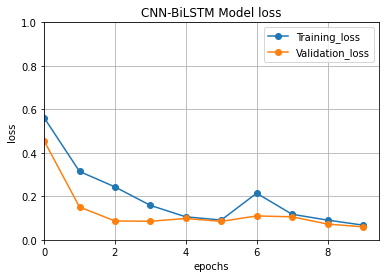

In [58]:
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history_5.epoch, history_5.history['loss'], '-o', label='Training_loss')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='Validation_loss')
plt.title('CNN-BiLSTM Model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [59]:
predicted = model_2.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9870    1.0000    0.9935       228
           1     1.0000    0.9538    0.9764        65

    accuracy                         0.9898       293
   macro avg     0.9935    0.9769    0.9849       293
weighted avg     0.9899    0.9898    0.9897       293



In [60]:
# sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

In [61]:
plot_classification_report(report)
plt.savefig('CNN-BiLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.close()

[0.987, 1.0, 0.9935]
[1.0, 0.9538, 0.9764]
plotMat: [[0.987, 1.0, 0.9935], [1.0, 0.9538, 0.9764]]
support: [228, 65]


In [62]:
# df = pd.DataFrame(report).transpose()
# df.to_csv('Att-Based CNN-BiLSTM_class_report_'+ datetime.now().strftime("%Y%m%d") + '.csv')
# print(df)

In [63]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

Testing Accuracy: 0.989761
Testing Precision: 0.989894
Testing Recall: 0.989761
Testing F1 score: 0.989674


In [64]:
# append the results
df_results.loc['CNN-BiLSTM'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM,0.993136,0.993233,0.993174,0.993174,137.829258
CNN-BiLSTM,0.989674,0.989894,0.989761,0.989761,131.692195


# BASELINES MODELS

## 1D CNN CODE

In [65]:
# %%time
# Y_train=np.array(Y)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(encoded, Y_train, test_size=0.1, random_state=42, shuffle= True)

# # Vectorize the output sentence type classifcations to Keras readable format
# y_train=to_categorical(y_train, num_classes=2)
# y_test=to_categorical(y_test, num_classes=2)

In [66]:
# # check the shape of each set
# print("X_train shape: {}".format(trainX_data.shape))
# print("y_train shape: {}".format(Ytrain.shape))

# # print("X_train_sub shape: {}".format(X_train_sub.shape))
# # print("y_train_sub shape: {}".format(y_train_sub.shape))

# # print("X_val shape: {}".format(X_val.shape))
# # print("y_val shape: {}".format(y_val.shape))

# print("X_test shape: {}".format(testX_data.shape))
# print("y_test shape: {}".format(Ytest.shape))

In [67]:
%%time
Y_train=np.array(Y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(encoded, Y_train, test_size=0.1, random_state=42, shuffle= True)

# Vectorize the output sentence type classifcations to Keras readable format
y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

CPU times: user 1.8 ms, sys: 40 ms, total: 41.8 ms
Wall time: 20.8 ms


In [68]:
# check the shape of each set
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

# print("X_train_sub shape: {}".format(X_train_sub.shape))
# print("y_train_sub shape: {}".format(y_train_sub.shape))

# print("X_val shape: {}".format(X_val.shape))
# print("y_val shape: {}".format(y_val.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (2631, 5962)
y_train shape: (2631, 2)
X_test shape: (293, 5962)
y_test shape: (293, 2)


In [69]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 2631 
Test set size = 293


In [70]:
#Model Definition
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(Dropout(0.25))
model.add(SpatialDropout1D(spa_dropout_ratio))

model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
model.add(Dense(dense_units, activation='relu'))
model.add(Flatten()) # no need if used Global poooling
model.add(Dropout(dropout_ratio))

model.add(Dense(2, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))

######################## COMPILING THE MODEL ##################################
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = Adam(
        learning_rate=learning_rate, decay=learning_decay
    ),
#         optimizer='adam',
    metrics = [
        "accuracy",
#       "binary_accuracy",
        'categorical_accuracy',
#       tf.keras.metrics.AUC(),
#       tf.keras.metrics.Precision(),
#       tf.keras.metrics.Recall()
        ]
    )

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5962, 300)         81193800  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 5962, 300)        0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 5960, 50)          45050     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2980, 50)         0         
 1D)                                                             
                                                                 
 dense_4 (Dense)             (None, 2980, 64)          3264      
                                                                 
 flatten (Flatten)           (None, 190720)            0

In [71]:
checkpoint = ModelCheckpoint("1D_CNN_"+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint, earlystopping]

# fit network
start_time = time()
history_2 = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_split=0.11111111111111111111111111111)
train_time = time() - start_time
print(train_time)

Epoch 1/10
34/37 [==========================>...] - ETA: 0s - loss: 0.2045 - accuracy: 0.9182 - categorical_accuracy: 0.9182
Epoch 1: loss improved from inf to 0.19461, saving model to 1D_CNN_20220607_17:16:20.h5
37/37 [==============================] - 2s 49ms/step - loss: 0.1946 - accuracy: 0.9234 - categorical_accuracy: 0.9234 - val_loss: 0.0999 - val_accuracy: 0.9659 - val_categorical_accuracy: 0.9659
Epoch 2/10
34/37 [==========================>...] - ETA: 0s - loss: 0.0834 - accuracy: 0.9743 - categorical_accuracy: 0.9743
Epoch 2: loss improved from 0.19461 to 0.08080, saving model to 1D_CNN_20220607_17:16:20.h5
37/37 [==============================] - 2s 45ms/step - loss: 0.0808 - accuracy: 0.9748 - categorical_accuracy: 0.9748 - val_loss: 0.0506 - val_accuracy: 0.9863 - val_categorical_accuracy: 0.9863
Epoch 3/10
34/37 [==========================>...] - ETA: 0s - loss: 0.0309 - accuracy: 0.9871 - categorical_accuracy: 0.9871
Epoch 3: loss improved from 0.08080 to 0.02981, savin

In [72]:
predicted = model.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9956    0.9825    0.9890       228
           1     0.9412    0.9846    0.9624        65

    accuracy                         0.9829       293
   macro avg     0.9684    0.9835    0.9757       293
weighted avg     0.9835    0.9829    0.9831       293



In [73]:
# df = pd.DataFrame(report).transpose()
# df.to_csv('CNN-BiLSTM_class_report_'+ datetime.now().strftime("%Y%m%d") + '.csv')
# print(df)

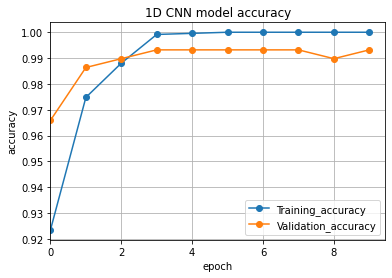

In [74]:
plt.plot(history_2.epoch, history_2.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('1D CNN model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

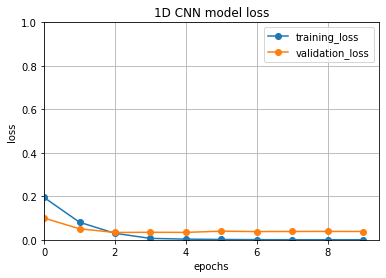

In [75]:
plt.plot(history_2.epoch, history_2.history['loss'], '-o', label='training_loss')
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.title('1D CNN model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [76]:
plot_classification_report(report)
plt.savefig('1D_CNN__plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.close()

[0.9956, 0.9825, 0.989]
[0.9412, 0.9846, 0.9624]
plotMat: [[0.9956, 0.9825, 0.989], [0.9412, 0.9846, 0.9624]]
support: [228, 65]


In [77]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

Testing Accuracy: 0.982935
Testing Precision: 0.983492
Testing Recall: 0.982935
Testing F1 score: 0.983071


In [78]:
# append the results
df_results.loc['1D_CNN'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM,0.993136,0.993233,0.993174,0.993174,137.829258
CNN-BiLSTM,0.989674,0.989894,0.989761,0.989761,131.692195
1D_CNN,0.983071,0.983492,0.982935,0.982935,18.607314


## LSTM CODE

In [79]:
# Y_train=np.array(Y)

# # Split the data
# trainX_data, testX_data, Y_TRAIN, Y_TEST = train_test_split(encoded, Y_train, test_size=0.1, shuffle= True)


# #set the Y variable as categorical
# Ytrain=to_categorical(Y_TRAIN,num_classes=2)
# Ytest=to_categorical(Y_TEST,num_classes=2)

In [80]:
# # check the shape of each set
# print("X_train shape: {}".format(trainX_data.shape))
# print("y_train shape: {}".format(Ytrain.shape))

# # print("X_train_sub shape: {}".format(X_train_sub.shape))
# # print("y_train_sub shape: {}".format(y_train_sub.shape))

# # print("X_val shape: {}".format(X_val.shape))
# # print("y_val shape: {}".format(y_val.shape))

# print("X_test shape: {}".format(testX_data.shape))
# print("y_test shape: {}".format(Ytest.shape))

In [81]:
%%time
Y_train=np.array(Y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(encoded, Y_train, test_size=0.1, random_state=42, shuffle= True)

# Vectorize the output sentence type classifcations to Keras readable format
y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

CPU times: user 15.1 ms, sys: 36.5 ms, total: 51.6 ms
Wall time: 17.3 ms


In [82]:
# check the shape of each set
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

# print("X_train_sub shape: {}".format(X_train_sub.shape))
# print("y_train_sub shape: {}".format(y_train_sub.shape))

# print("X_val shape: {}".format(X_val.shape))
# print("y_val shape: {}".format(y_val.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (2631, 5962)
y_train shape: (2631, 2)
X_test shape: (293, 5962)
y_test shape: (293, 2)


In [83]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 2631 
Test set size = 293


In [84]:
#Model Definition
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(Dropout(0.25))
model.add(SpatialDropout1D(spa_dropout_ratio))

model.add(LSTM(lstm_units_1,return_sequences=True))
# model.add(Dropout(dropout_ratio))
model.add(LSTM(lstm_units_2))
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(dropout_ratio))

model.add(Dense(2, activation='softmax'))
    
######################## COMPILING THE MODEL ##################################
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = Adam(
        learning_rate=learning_rate, decay=learning_decay
    ),
#         optimizer='adam',
    metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5962, 300)         81193800  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 5962, 300)        0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 5962, 64)          93440     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [85]:
checkpoint = ModelCheckpoint("LSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint,earlystopping]

# fit network
start_time = time()
history_3 = model.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_split=0.11111111111111111111111111111)
train_time = time() - start_time
print(train_time)

Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7549 - categorical_accuracy: 0.7549
Epoch 1: loss improved from inf to 0.56180, saving model to LSTM_20220607_17-16-42.h5
37/37 [==============================] - 16s 360ms/step - loss: 0.5618 - accuracy: 0.7549 - categorical_accuracy: 0.7549 - val_loss: 0.4451 - val_accuracy: 0.8430 - val_categorical_accuracy: 0.8430
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8610 - categorical_accuracy: 0.8610
Epoch 2: loss improved from 0.56180 to 0.33567, saving model to LSTM_20220607_17-16-42.h5
37/37 [==============================] - 13s 345ms/step - loss: 0.3357 - accuracy: 0.8610 - categorical_accuracy: 0.8610 - val_loss: 0.0798 - val_accuracy: 0.9863 - val_categorical_accuracy: 0.9863
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7904 - categorical_accuracy: 0.7904
Epoch 3: loss did not improve from 0.33567
37/37 [===

In [86]:
predicted = model.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9701    0.9956    0.9827       228
           1     0.9831    0.8923    0.9355        65

    accuracy                         0.9727       293
   macro avg     0.9766    0.9440    0.9591       293
weighted avg     0.9730    0.9727    0.9722       293



In [87]:
# df = pd.DataFrame(report).transpose()
# df.to_csv('CNN-BiLSTM_class_report_'+ datetime.now().strftime("%Y%m%d") + '.csv')
# print(df)

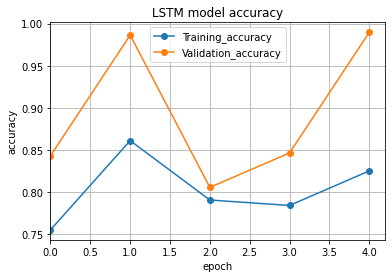

In [88]:
plt.plot(history_3.epoch, history_3.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_3.epoch, history_3.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('LSTM model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('LSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('LSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

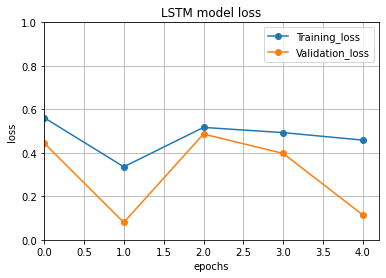

In [89]:
plt.plot(history_3.epoch, history_3.history['loss'], '-o', label='Training_loss')
plt.plot(history_3.epoch, history_3.history['val_loss'], '-o', label='Validation_loss')
plt.legend()
plt.title('LSTM model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('LSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('LSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [90]:
plot_classification_report(report)
plt.savefig('LSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.close()

[0.9701, 0.9956, 0.9827]
[0.9831, 0.8923, 0.9355]
plotMat: [[0.9701, 0.9956, 0.9827], [0.9831, 0.8923, 0.9355]]
support: [228, 65]


In [91]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

Testing Accuracy: 0.972696
Testing Precision: 0.972962
Testing Recall: 0.972696
Testing F1 score: 0.972213


In [92]:
# append the results
df_results.loc['LSTM'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM,0.993136,0.993233,0.993174,0.993174,137.829258
CNN-BiLSTM,0.989674,0.989894,0.989761,0.989761,131.692195
1D_CNN,0.983071,0.983492,0.982935,0.982935,18.607314
LSTM,0.972213,0.972962,0.972696,0.972696,63.070008


## AX BiLSTM CODE

In [93]:
# Y_train=np.array(Y)

# # Split the data
# trainX_data, testX_data, Y_TRAIN, Y_TEST = train_test_split(encoded, Y_train, test_size=0.1, shuffle= True)


# #set the Y variable as categorical
# Ytrain=to_categorical(Y_TRAIN,num_classes=2)
# Ytest=to_categorical(Y_TEST,num_classes=2)

In [94]:
# # check the shape of each set
# print("X_train shape: {}".format(trainX_data.shape))
# print("y_train shape: {}".format(Ytrain.shape))

# # print("X_train_sub shape: {}".format(X_train_sub.shape))
# # print("y_train_sub shape: {}".format(y_train_sub.shape))

# # print("X_val shape: {}".format(X_val.shape))
# # print("y_val shape: {}".format(y_val.shape))

# print("X_test shape: {}".format(testX_data.shape))
# print("y_test shape: {}".format(Ytest.shape))

In [95]:
%%time
Y_train=np.array(Y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(encoded, Y_train, test_size=0.1, random_state=42, shuffle= True)

# Vectorize the output sentence type classifcations to Keras readable format
y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

CPU times: user 19.5 ms, sys: 32.1 ms, total: 51.6 ms
Wall time: 19.2 ms


In [96]:
# check the shape of each set
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

# print("X_train_sub shape: {}".format(X_train_sub.shape))
# print("y_train_sub shape: {}".format(y_train_sub.shape))

# print("X_val shape: {}".format(X_val.shape))
# print("y_val shape: {}".format(y_val.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (2631, 5962)
y_train shape: (2631, 2)
X_test shape: (293, 5962)
y_test shape: (293, 2)


In [97]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 2631 
Test set size = 293


In [98]:
#Model Definition
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(Dropout(0.25))
model.add(SpatialDropout1D(spa_dropout_ratio))

# model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(hidden_units, activation='relu'))
# model.add(Dropout(dropout_ratio))

model.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
# model.add(Dropout(dropout_ratio))
model.add(Bidirectional(LSTM(lstm_units_2)))
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(dropout_ratio))

model.add(Dense(2, activation='softmax'))
    
######################## COMPILING THE MODEL ##################################
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = Adam(
        learning_rate=learning_rate, decay=learning_decay
    ),
#         optimizer='adam',
    metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5962, 300)         81193800  
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 5962, 300)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 5962, 128)        186880    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                      

In [99]:
checkpoint = ModelCheckpoint("BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint,earlystopping]

# fit network
start_time = time()
history_4 = model.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_split=0.11111111111111111111111111111)
train_time = time() - start_time
print(train_time)

Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7558 - categorical_accuracy: 0.7558
Epoch 1: loss improved from inf to 0.57285, saving model to BiLSTM_20220607_17-17-52.h5
37/37 [==============================] - 29s 663ms/step - loss: 0.5728 - accuracy: 0.7558 - categorical_accuracy: 0.7558 - val_loss: 0.4776 - val_accuracy: 0.8055 - val_categorical_accuracy: 0.8055
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.7793 - categorical_accuracy: 0.7793
Epoch 2: loss improved from 0.57285 to 0.46149, saving model to BiLSTM_20220607_17-17-52.h5
37/37 [==============================] - 24s 637ms/step - loss: 0.4615 - accuracy: 0.7793 - categorical_accuracy: 0.7793 - val_loss: 0.2760 - val_accuracy: 0.9147 - val_categorical_accuracy: 0.9147
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8037 - categorical_accuracy: 0.8037
Epoch 3: loss improved from 0.46149 to 0.35371, s

In [100]:
predicted = model.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8894    0.9167    0.9028       228
           1     0.6724    0.6000    0.6341        65

    accuracy                         0.8464       293
   macro avg     0.7809    0.7583    0.7685       293
weighted avg     0.8412    0.8464    0.8432       293



In [101]:
# df = pd.DataFrame(report).transpose()
# df.to_csv('CNN-BiLSTM_class_report_'+ datetime.now().strftime("%Y%m%d") + '.csv')
# print(df)

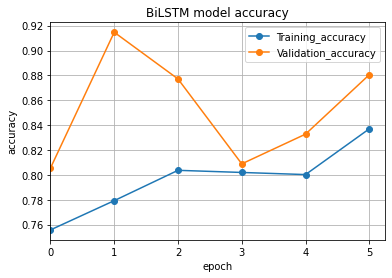

In [102]:
plt.plot(history_4.epoch, history_4.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('BiLSTM model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

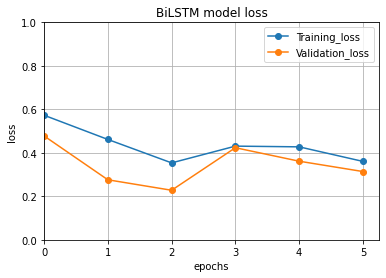

In [103]:
plt.plot(history_4.epoch, history_4.history['loss'], '-o', label='Training_loss')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='Validation_loss')
plt.legend()
plt.title('BiLSTM model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [104]:
plot_classification_report(report)
plt.savefig('BiLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.close()

[0.8894, 0.9167, 0.9028]
[0.6724, 0.6, 0.6341]
plotMat: [[0.8894, 0.9167, 0.9028], [0.6724, 0.6, 0.6341]]
support: [228, 65]


In [105]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

Testing Accuracy: 0.846416
Testing Precision: 0.841233
Testing Recall: 0.846416
Testing F1 score: 0.843207


In [106]:
# append the results
df_results.loc['BiLSTM'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM,0.993136,0.993233,0.993174,0.993174,137.829258
CNN-BiLSTM,0.989674,0.989894,0.989761,0.989761,131.692195
1D_CNN,0.983071,0.983492,0.982935,0.982935,18.607314
LSTM,0.972213,0.972962,0.972696,0.972696,63.070008
BiLSTM,0.843207,0.841233,0.846416,0.846416,143.342117


## save the results in csv

In [107]:
# save the training results
df_results.to_csv("Models_performance_summary_" + datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".csv")

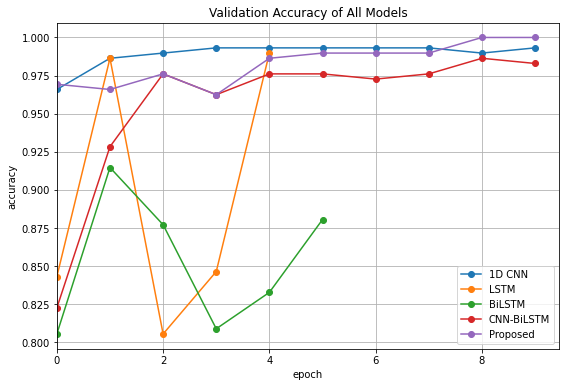

In [111]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='1D CNN')
plt.plot(history_3.epoch, history_3.history['val_accuracy'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Proposed')
plt.title('Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

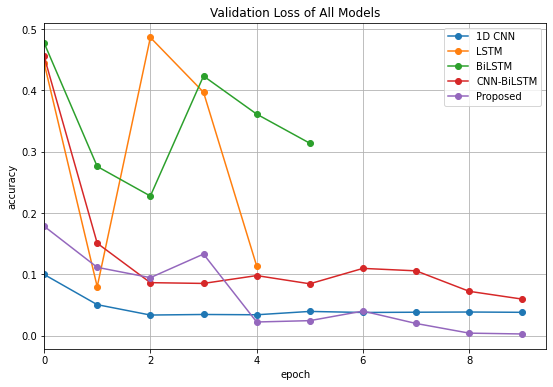

In [109]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='1D CNN')
plt.plot(history_3.epoch, history_3.history['val_loss'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Proposed')
plt.title('Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()